Part 2

12. ResNet50

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import cv2 as cv

from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
import os

Data preprocessing

In [4]:
# Set the base directory for the Jute Pest Dataset and define image parameters
base_dir = "Jute_Pest_Dataset/Jute_Pest_Dataset"
batch_size = 32
img_height = 224
img_width = 224

# Define directories for training, validation, and test datasets
train_dir = f'{base_dir}/train'
val_dir = f'{base_dir}/val'
test_dir = f'{base_dir}/test'

# Load and preprocess the training dataset with specified image size and batch size
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Save the class names from the training dataset for reference
class_names = train_ds.class_names

# Load and preprocess the validation dataset with the same parameters
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  val_dir,
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Load and preprocess the test dataset, using similar parameters
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Define data augmentation layer with random transformations to improve model generalization
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal_and_vertical"),  # Randomly flip images horizontally and vertically
    keras.layers.RandomRotation(0.2),                    # Apply random rotation to images
    keras.layers.RandomZoom(0.2),                        # Zoom images randomly
    keras.layers.RandomContrast(0.1)                     # Adjust image contrast randomly
])

# Apply data augmentation to the training dataset
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))



Found 6443 files belonging to 17 classes.
Found 413 files belonging to 17 classes.
Found 379 files belonging to 17 classes.


13, 14, 15, 16

In [5]:
# Set parameters
img_height = 224
img_width = 224
num_classes = 17

batch_epochs = 5  # Train 10 epochs at a time
total_epochs = 10  # Initial training: 10 epochs
fine_tune_total_epochs = 10  # Fine-tuning: 10 epochs

# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False  # Freeze base model's layers

# Build the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Directory to save model checkpoints
checkpoint_dir = "model_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Resume from the latest checkpoint if exists
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
if latest_checkpoint:
    print(f"Resuming from checkpoint: {latest_checkpoint}")
    model = tf.keras.models.load_model(latest_checkpoint)
    initial_epoch = int(latest_checkpoint.split('_')[-1].split('.')[0])  # Extract epoch number
else:
    print("No checkpoint found, starting from scratch.")
    initial_epoch = 0

# Initial Training: Train in chunks of 10 epochs
for start_epoch in range(initial_epoch, total_epochs, batch_epochs):
    end_epoch = min(start_epoch + batch_epochs, total_epochs)
    print(f"Training initial epochs {start_epoch + 1} to {end_epoch}...")

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        initial_epoch=start_epoch,
        epochs=end_epoch
    )

    checkpoint_path = os.path.join(checkpoint_dir, f"model_initial_epoch_{end_epoch}.h5")
    model.save(checkpoint_path)
    print(f"Model saved to {checkpoint_path}")

# Fine-Tuning: Unfreeze some layers and re-train
base_model.trainable = True
for layer in base_model.layers[:-10]:  # Freeze all but the last 10 layers
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fine-tuning: Train in chunks of 10 epochs
for start_epoch in range(total_epochs, total_epochs + fine_tune_total_epochs, batch_epochs):
    end_epoch = min(start_epoch + batch_epochs, total_epochs + fine_tune_total_epochs)
    print(f"Fine-tuning epochs {start_epoch + 1} to {end_epoch}...")

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        initial_epoch=start_epoch,
        epochs=end_epoch
    )

    checkpoint_path = os.path.join(checkpoint_dir, f"model_finetune_epoch_{end_epoch}.h5")
    model.save(checkpoint_path)
    print(f"Model saved to {checkpoint_path}")


Training initial epochs 1 to 5...
Epoch 1/5
202/202 ━━━━━━━━━━━━━━━━━━━━ 616s 3s/step - accuracy: 0.3942 - loss: 1.9870 - val_accuracy: 0.7385 - val_loss: 0.8688
Epoch 2/5
202/202 ━━━━━━━━━━━━━━━━━━━━ 577s 3s/step - accuracy: 0.7498 - loss: 0.7774 - val_accuracy: 0.8111 - val_loss: 0.6795
Epoch 3/5
202/202 ━━━━━━━━━━━━━━━━━━━━ 599s 3s/step - accuracy: 0.8145 - loss: 0.5609 - val_accuracy: 0.8281 - val_loss: 0.6201
Epoch 4/5
202/202 ━━━━━━━━━━━━━━━━━━━━ 555s 3s/step - accuracy: 0.8555 - loss: 0.4546 - val_accuracy: 0.8402 - val_loss: 0.6134
Epoch 5/5
202/202 ━━━━━━━━━━━━━━━━━━━━ 567s 3s/step - accuracy: 0.8759 - loss: 0.3752 - val_accuracy: 0.8596 - val_loss: 0.5455


Model saved to model_checkpoints\model_initial_epoch_5.h5
Training initial epochs 6 to 10...
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 528s 3s/step - accuracy: 0.8812 - loss: 0.3605 - val_accuracy: 0.8668 - val_loss: 0.4751
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 552s 3s/step - accuracy: 0.8923 - loss: 0.3336 - val_accuracy: 0.8547 - val_loss: 0.4988
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 569s 3s/step - accuracy: 0.9000 - loss: 0.2904 - val_accuracy: 0.8547 - val_loss: 0.4859
Epoch 9/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 508s 3s/step - accuracy: 0.9083 - loss: 0.2831 - val_accuracy: 0.8644 - val_loss: 0.4726
Epoch 10/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 505s 2s/step - accuracy: 0.9067 - loss: 0.2727 - val_accuracy: 0.8765 - val_loss: 0.5009


Model saved to model_checkpoints\model_initial_epoch_10.h5
Fine-tuning epochs 11 to 15...
Epoch 11/15
202/202 ━━━━━━━━━━━━━━━━━━━━ 598s 3s/step - accuracy: 0.9119 - loss: 0.2616 - val_accuracy: 0.8789 - val_loss: 0.5173
Epoch 12/15
202/202 ━━━━━━━━━━━━━━━━━━━━ 571s 3s/step - accuracy: 0.9382 - loss: 0.2092 - val_accuracy: 0.8862 - val_loss: 0.5281
Epoch 13/15
202/202 ━━━━━━━━━━━━━━━━━━━━ 730s 4s/step - accuracy: 0.9338 - loss: 0.1967 - val_accuracy: 0.8814 - val_loss: 0.5031
Epoch 14/15
202/202 ━━━━━━━━━━━━━━━━━━━━ 985s 5s/step - accuracy: 0.9456 - loss: 0.1711 - val_accuracy: 0.8886 - val_loss: 0.4978
Epoch 15/15
202/202 ━━━━━━━━━━━━━━━━━━━━ 984s 5s/step - accuracy: 0.9477 - loss: 0.1596 - val_accuracy: 0.8789 - val_loss: 0.5227


Model saved to model_checkpoints\model_finetune_epoch_15.h5
Fine-tuning epochs 16 to 20...
Epoch 16/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 889s 4s/step - accuracy: 0.9583 - loss: 0.1370 - val_accuracy: 0.8838 - val_loss: 0.5088
Epoch 17/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 703s 3s/step - accuracy: 0.9576 - loss: 0.1404 - val_accuracy: 0.8838 - val_loss: 0.5383
Epoch 18/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 668s 3s/step - accuracy: 0.9574 - loss: 0.1361 - val_accuracy: 0.8789 - val_loss: 0.5207
Epoch 19/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 662s 3s/step - accuracy: 0.9616 - loss: 0.1205 - val_accuracy: 0.8886 - val_loss: 0.5053
Epoch 20/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 656s 3s/step - accuracy: 0.9604 - loss: 0.1261 - val_accuracy: 0.8741 - val_loss: 0.5488


Model saved to model_checkpoints\model_finetune_epoch_20.h5


In [7]:
model.save('TrainedModel.h5')

12/12 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9541 - loss: 0.2009
Test Accuracy of fine-tuned ResNet-50: 0.97
Test Loss of fine-tuned ResNet-50: 0.10


[]

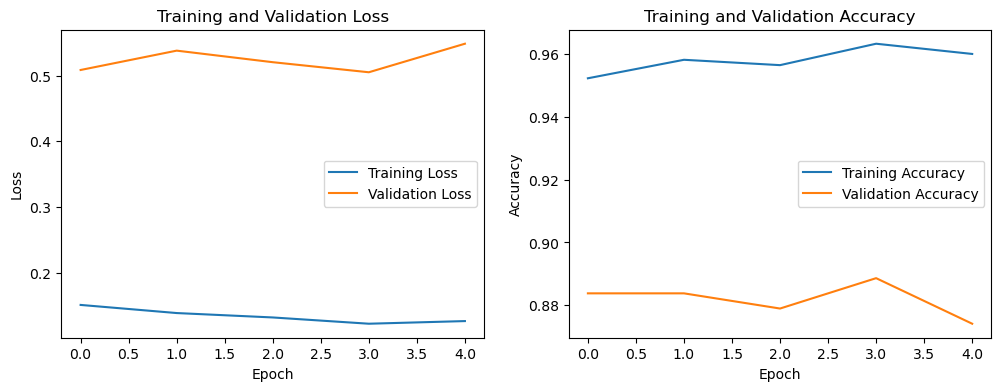

In [11]:
from matplotlib import pyplot as plt

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy of fine-tuned ResNet-50: {test_accuracy:.2f}")
print(f"Test Loss of fine-tuned ResNet-50: {test_loss:.2f}")

# Record losses and accuracy for plotting
train_loss = history.history['loss'] 
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy'] 
val_accuracy = history.history['val_accuracy']

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.plot()